In [1]:
import numpy as np
from matplotlib import pyplot as plt

## 1. 线性不可分双月数据集的训练

In [2]:
def dbmoon(N=100, d=2, r=10, w=2):
    '''生成双月数据集
    
    Args:
        N: 数据集数量
        d: 双月之间的距离
        r: 双月半径
        w: 每个月亮的厚度
        
    Returns:
        返回一个`shape=[N * 2, 2]`的数组，前100个元素表示
        上半月，后100个元素表示下半月。
    '''
    w2 = w / 2
    data = np.empty(0)
    while data.shape[0] < N:
        #generate Rectangular data
        tmp_x = 2 * (r + w2) * (np.random.random([N, 1]) - 0.5)
        tmp_y = (r + w2) * np.random.random([N, 1])
        tmp = np.concatenate((tmp_x, tmp_y), axis=1)
        tmp_ds = np.sqrt(tmp_x * tmp_x + tmp_y * tmp_y)
        #generate double moon data ---upper
        idx = np.logical_and(tmp_ds > (r - w2), tmp_ds < (r + w2))
        idx = (idx.nonzero())[0]

        if data.shape[0] == 0:
            data = tmp.take(idx, axis=0)
        else:
            data = np.concatenate((data, tmp.take(idx, axis=0)), axis=0)
    
    db_moon = data[0: N, :]
    #generate double moon data ----down
    data_t = np.empty([N, 2])
    data_t[:, 0] = data[0: N, 0] + r
    data_t[:, 1] = -data[0: N, 1] - d
    db_moon = np.concatenate((db_moon, data_t), axis=0)
    return db_moon

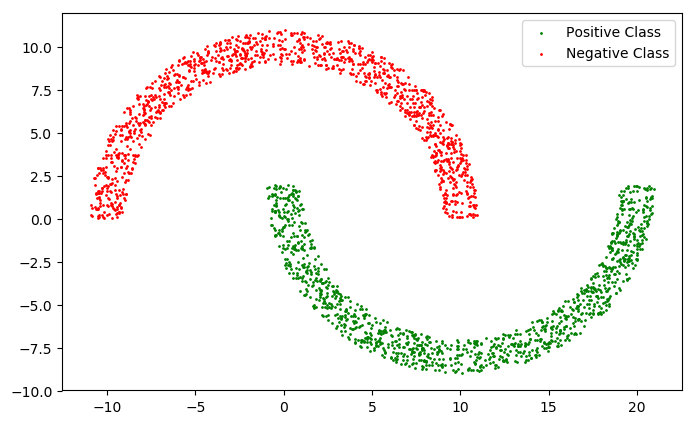

In [45]:
# 生成数据集
num_example = 2500
x =  dbmoon(N=num_example // 2, d=-2)
y = np.concatenate([np.ones([num_example // 2]), -np.ones([num_example // 2])])

plt.figure(figsize=(8, 5), dpi=100)
plt.scatter(x[num_example // 2:, 0], x[num_example // 2:, 1], 1, color='green', label='Positive Class')
plt.legend(loc='best')
plt.scatter(x[: num_example // 2, 0], x[: num_example // 2, 1], 1, color='red', label='Negative Class')
plt.legend(loc='best')
plt.show()

In [46]:
from sklearn.model_selection import train_test_split

# 将数据集打乱并分为训练集与测试集
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=500)

In [5]:
w = np.zeros([2], dtype=np.float32)
b = 0.

def rosenblatt(x):
    z = np.sum(w * x) + b
    return 1 if z >=0 else -1

In [31]:
from sklearn.metrics import mean_squared_error

# 训练模型 10000 次
train_steps = 10000
# 摘要频率
summary_step = 50
# 摘要，记录训练中的代价变化
summary = np.empty([train_steps // summary_step, 2])
# 学习率
lr = 0.1

for i in range(0, train_steps):
    # 评估模型
    if i % summary_step == 0:
        test_out = [rosenblatt(test) for test in test_x]
        loss = mean_squared_error(test_y, test_out)
        summary[i // summary_step] = np.array([i, loss])
    
    # 取一个训练集中的样本
    one_x, one_y = train_x[i % train_y.shape[0]], train_y[i % train_y.shape[0]]
    # 得到模型输出结果
    out = rosenblatt(one_x)
    # 更新权值
    w = w + lr * (one_y - out) * one_x
    b = b + lr * (one_y - out)

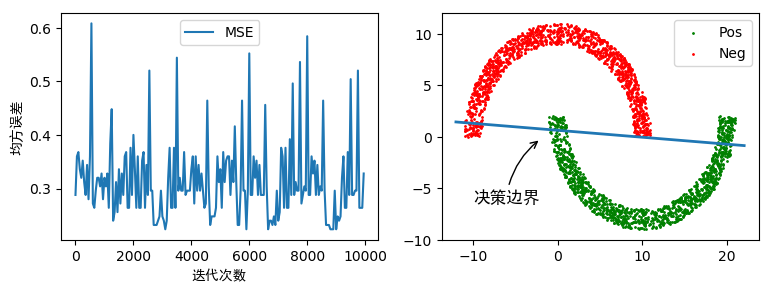

In [32]:
plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1, 2, 1)
plt.plot(summary[:, 0], summary[:, 1], label='MSE')
plt.legend(loc='best')
plt.xlabel('迭代次数', fontproperties='SimHei')
plt.ylabel('均方误差', fontproperties='SimHei')

plt.subplot(1, 2, 2)
plt.scatter(x[num_example // 2:, 0], x[num_example // 2:, 1], 1, color='green', label='Pos')
plt.legend(loc='best')
plt.scatter(x[: num_example // 2, 0], x[: num_example // 2, 1], 1, color='red', label='Neg')
plt.legend(loc='best')
left_coord_y = (-b - (-12) * w[0]) / w[1]
right_coord_y = (-b - (22) * w[0]) / w[1]
plt.plot([-12, 22], [left_coord_y, right_coord_y], linewidth=2)

plt.annotate(
    '决策边界', xy=(-2, -0.2), xytext=(-10., -6.5), 
     arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"), 
     fontproperties='SimHei', fontsize=12)

plt.show()

## 2. 学习率衰减实现

In [48]:
# 训练模型 10000 次
train_steps = 10000
# 摘要频率
summary_step = 50
# 摘要，记录训练中的代价变化
# summary = np.empty([train_steps // summary_step, 2])
summary = []
# 初始学习率，随着迭代次数将逐步衰减
lr = 0.1
decay_rate = 0.95

for i in range(0, train_steps):
    # 评估模型
    if i % summary_step == 0:
        test_out = [rosenblatt(test) for test in test_x]
        loss = mean_squared_error(test_y, test_out)
        summary.append(np.array([i, loss]))
#         summary[i // summary_step] = np.array([i, loss])
    # 取一个训练集中的样本
    one_x, one_y = train_x[i % train_y.shape[0]], train_y[i % train_y.shape[0]]
    # 得到模型输出结果
    out = rosenblatt(one_x)
    # 更新权值
    w = w + lr * (one_y - out) * one_x
    b = b + lr * (one_y - out)
    
    # 设定阈值为0.2，当loss不大于0.2时，可以认为模型已经收敛
    if loss <= 0.2:  
        print("训练到第%d轮，已经接近收敛，停止训练" % i)
        break
    # 学习率衰减，每迭代1000次衰减1次
    if (i + 1) % 1000 == 0:
        if lr > 1e-4:
            lr = pow(decay_rate, (i + 1) / 1000) * lr
            print("第%d轮的学习率为%.15f" % (i, lr))

summary = np.array(summary)

第999轮的学习率为0.095000000000000
第1999轮的学习率为0.085737500000000
第2999轮的学习率为0.073509189062500
训练到第3850轮，已经接近收敛，停止训练


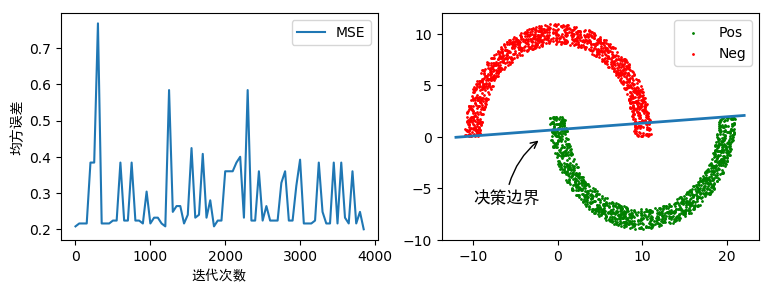

In [49]:
plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1, 2, 1)
plt.plot(summary[:, 0], summary[:, 1], label='MSE')
plt.legend(loc='best')
plt.xlabel('迭代次数', fontproperties='SimHei')
plt.ylabel('均方误差', fontproperties='SimHei')

plt.subplot(1, 2, 2)
plt.scatter(x[num_example // 2:, 0], x[num_example // 2:, 1], 1, color='green', label='Pos')
plt.legend(loc='best')
plt.scatter(x[: num_example // 2, 0], x[: num_example // 2, 1], 1, color='red', label='Neg')
plt.legend(loc='best')
left_coord_y = (-b - (-12) * w[0]) / w[1]
right_coord_y = (-b - (22) * w[0]) / w[1]
plt.plot([-12, 22], [left_coord_y, right_coord_y], linewidth=2)

plt.annotate(
    '决策边界', xy=(-2, -0.2), xytext=(-10., -6.5), 
     arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"), 
     fontproperties='SimHei', fontsize=12)

plt.show()